# **Processing Text - Final Project**

**04. Sentiment Analysis**

SENTIMENT AND PUBLIC OPINION ANALYSIS ON THE NEW MINISTER OF FINANCE, PURBAYA YUDHI SADEWA, ON THE YOUTUBE PLATFORM USING INDOBERT, DBSCAN, K-MEANS CLUSTERING, AND PROPHET

The Member of the Group 5 of Final Project

- Abdullah Al-Firdaus Nuzula 	(24031554008)
- Halilatunnisa 			        (24031554130)
- Elvira Tiara Suci Tambunan 	(24031554213)

Lecturer: Ulfa Siti Nuraini, S.Stat., M.Stat.

## **Install Library**

In [ ]:
!pip install -q transformers datasets evaluate accelerate scikit-learn sentencepiece

## **Set Seed dan Import Library**

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Using 100 Labeled Data**

## **Load Dataset**

In [ ]:
indobert_file = "/content/drive/MyDrive/Akademik - UNESA /Semester 3/Processing Text/008_130_213_Group5_PemteksFinalProject/Cleaning Data Result/Cleaning_Data_IndoBERT_Labeled_100.xlsx"

In [ ]:
import pandas as pd
from IPython.display import display

df = pd.read_excel(indobert_file)
display(df.head())

,text_display,cleaned_text,published_at,author,like_count,label
0,Bagus pak Purbaya sikat kalau sdh ngaco berhub...,bagus bapak purbaya sikat kalau sudah ngaco be...,2025-11-07 09:33:05,@hendywirawan6870,0,positive
1,Bener sekali kalo mau pinjam kur harus ada ang...,benar sekali kalau mau pinjam kur harus ada an...,2025-11-07 09:32:53,@Farah-hl5ct,0,positive
2,mantul pak menkeu,mantul bapak menteri keuangan,2025-11-07 07:55:01,@indrapujiwiyatno,0,positive
3,kita baru tahu slama bertahun2 slama ini baru ...,kita baru tahu slama bertahun slama ini baru a...,2025-11-06 19:33:45,@marliaheumarvggy5850,0,negative
4,pak purbaya sehat selalu panjang umur,bapak purbaya sehat selalu panjang umur,2025-11-06 19:31:00,@marliaheumarvggy5850,0,positive


## **Labeled Data**

### **Filter Labeled Data and Prepare Text Columns**

In [ ]:
print("Columns in DataFrame df:", df.columns)
df_labeled = df[df['label'].notnull()].copy()
print(f"Jumlah data berlabel: {len(df_labeled)}")

text_column = 'cleaned_text'
if text_column not in df_labeled.columns:
    df_labeled[text_column] = ""

df_labeled.loc[:, text_column] = df_labeled[text_column].astype(str).fillna("")
display(df_labeled.head())

Columns in DataFrame df: Index(['text_display', 'cleaned_text', 'published_at', 'author', 'like_count',
       'label'],
      dtype='object')
Jumlah data berlabel: 100


,text_display,cleaned_text,published_at,author,like_count,label
0,Bagus pak Purbaya sikat kalau sdh ngaco berhub...,bagus bapak purbaya sikat kalau sudah ngaco be...,2025-11-07 09:33:05,@hendywirawan6870,0,positive
1,Bener sekali kalo mau pinjam kur harus ada ang...,benar sekali kalau mau pinjam kur harus ada an...,2025-11-07 09:32:53,@Farah-hl5ct,0,positive
2,mantul pak menkeu,mantul bapak menteri keuangan,2025-11-07 07:55:01,@indrapujiwiyatno,0,positive
3,kita baru tahu slama bertahun2 slama ini baru ...,kita baru tahu slama bertahun slama ini baru a...,2025-11-06 19:33:45,@marliaheumarvggy5850,0,negative
4,pak purbaya sehat selalu panjang umur,bapak purbaya sehat selalu panjang umur,2025-11-06 19:31:00,@marliaheumarvggy5850,0,positive


### **Label Encoding and Tokenizer**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
le = LabelEncoder()
df_labeled['label_id'] = le.fit_transform(df_labeled['label'])

def tokenize_function(texts, max_len=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

### **Dataset Class**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

### **Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_labeled[text_column].tolist(),
    df_labeled['label_id'].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=df_labeled['label_id']
)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

train_dataset = CommentDataset(train_encodings, train_labels)
val_dataset = CommentDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### **Load Model and Optimizer**

In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=len(le.classes_)
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Training Loop with Early Stopping**

In [ ]:
from tqdm import tqdm

epochs = 5
best_val_loss = float('inf')
patience = 2
trigger_times = 0

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
            val_loss += outputs.loss.item()
    val_loss /= len(val_loader)
    print(f"Validation loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

  0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s, loss=1.43]


Validation loss: 0.9551


Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s, loss=0.564]


Validation loss: 0.7694


Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s, loss=0.211]


Validation loss: 0.7267


Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s, loss=0.0473]


Validation loss: 0.7632


Epoch 5: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s, loss=0.0427]


Validation loss: 0.9669
Early stopping!


### **Load Best Model**

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

### **Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=le.classes_)
print(f"Validation accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Validation accuracy: 0.7333
Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.91      0.80        11
     neutral       1.00      0.29      0.44         7
    positive       0.71      0.83      0.77        12

    accuracy                           0.73        30
   macro avg       0.81      0.68      0.67        30
weighted avg       0.78      0.73      0.70        30



## **Unlabeled Data**

### **Unlabeled Data Prediction (Confidence Filtering)**

In [ ]:
confidence_threshold = 0.9
df_unlabeled = df[df['label'].isnull()].copy()
df_unlabeled.loc[:, text_column] = df_unlabeled[text_column].astype(str).fillna("")

batch_size = 16
all_preds, all_confs = [], []

model.eval()
for i in range(0, len(df_unlabeled), batch_size):
    batch_texts = df_unlabeled[text_column][i:i+batch_size].tolist()
    enc_batch = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    enc_batch = {k: v.to(device) for k, v in enc_batch.items()}

    with torch.no_grad():
        outputs = model(**enc_batch)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confs, pred_ids = torch.max(probs, dim=1)

    all_preds.extend(pred_ids.cpu().numpy())
    all_confs.extend(confs.cpu().numpy())

df_unlabeled['pred_label'] = le.inverse_transform(all_preds)
df_unlabeled['confidence'] = all_confs

df_confident_high = df_unlabeled[df_unlabeled['confidence'] >= confidence_threshold].copy()
print(f"High number of confident comments: {len(df_confident_high)}")

df_confident_high['label_id'] = le.transform(df_confident_high['pred_label'])

High number of confident comments: 2253


## **Combine Labeled and Confident Data for Fine-tune**

In [ ]:
df_finetune = pd.concat([
    df_labeled,
    df_confident_high[[text_column,'pred_label','label_id']].rename(columns={'pred_label':'label'})
], ignore_index=True)

print(f"Total data for fine-tune: {len(df_finetune)}")

encodings_finetune = tokenize_function(df_finetune[text_column].tolist())
labels_finetune = df_finetune['label_id'].tolist()
dataset_finetune = CommentDataset(encodings_finetune, labels_finetune)
dataloader_finetune = DataLoader(dataset_finetune, batch_size=16, shuffle=True)

Total data for fine-tune: 2353


### **Fine-tune Model**

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 2

for epoch in range(epochs):
    model.train()
    loop = tqdm(dataloader_finetune, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Fine-tune Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())

Fine-tune Epoch 2: 100%|██████████| 148/148 [00:50<00:00,  2.95it/s, loss=0.0007]


## **Final Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=le.classes_)
print(f"Final validation accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Final validation accuracy: 0.8667
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      1.00      0.92        11
     neutral       1.00      0.57      0.73         7
    positive       0.85      0.92      0.88        12

    accuracy                           0.87        30
   macro avg       0.90      0.83      0.84        30
weighted avg       0.88      0.87      0.86        30



## **Final Prediction of Unlabeled Data**

In [ ]:
all_preds, all_confs = [], []
for i in range(0, len(df_unlabeled), batch_size):
    batch_texts = df_unlabeled[text_column][i:i+batch_size].tolist()
    enc_batch = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    enc_batch = {k: v.to(device) for k, v in enc_batch.items()}

    with torch.no_grad():
        outputs = model(**enc_batch)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confs, pred_ids = torch.max(probs, dim=1)

    all_preds.extend(pred_ids.cpu().numpy())
    all_confs.extend(confs.cpu().numpy())

df_unlabeled['pred_label'] = le.inverse_transform(all_preds)
df_unlabeled['confidence'] = all_confs
df_unlabeled.index = df[df['label'].isnull()].index

df_final = df.copy()
df_final.loc[df_unlabeled.index, 'label'] = df_unlabeled['pred_label']

df_final.to_excel("Cleaning_Data_IndoBERT_Sentiment_Label.xlsx", index=False)
print("Done! File saved: Cleaning_Data_IndoBERT_Sentiment_Label.xlsx")
display(df_final[[text_column, 'published_at', 'label']].head(20))

Done! File saved: Cleaning_Data_IndoBERT_Sentiment_Label.xlsx


,cleaned_text,published_at,label
0,bagus bapak purbaya sikat kalau sudah ngaco be...,2025-11-07 09:33:05,positive
1,benar sekali kalau mau pinjam kur harus ada an...,2025-11-07 09:32:53,positive
2,mantul bapak menteri keuangan,2025-11-07 07:55:01,positive
3,kita baru tahu slama bertahun slama ini baru a...,2025-11-06 19:33:45,negative
4,bapak purbaya sehat selalu panjang umur,2025-11-06 19:31:00,positive
5,dipecat saja masih banyak orang orang pintar y...,2025-11-06 14:41:28,negative
6,baru kali ini lihat orang berbicara sombong ta...,2025-11-06 13:04:29,positive
7,betul semua diminta agunan kami yang di daerah...,2025-11-06 11:22:36,neutral
8,seharusnya danantara itu sebagai tempat ekseku...,2025-11-05 22:51:58,negative
9,saya pengguna kur dan memang boleh lah kalau u...,2025-11-05 22:48:10,neutral


#**Sentiment Distribution**

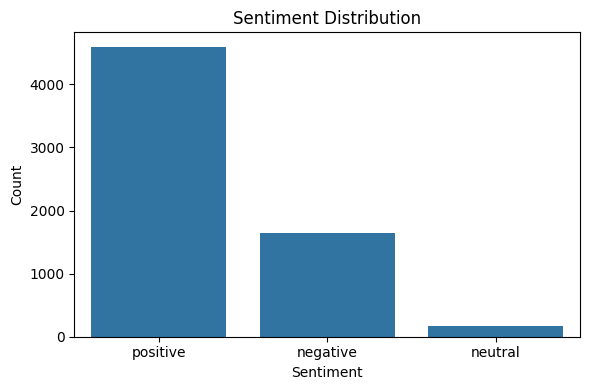

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df_final, x='label')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

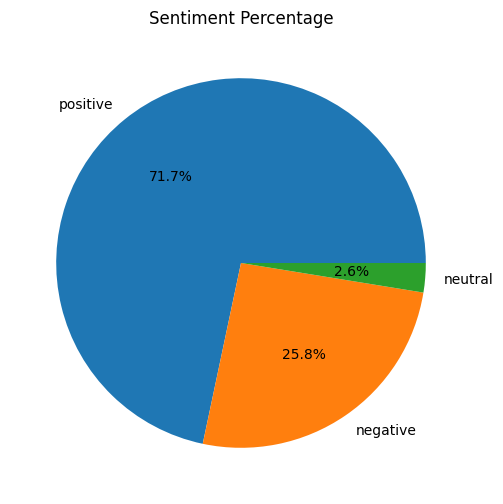

In [ ]:
plt.figure(figsize=(6,6))
df_final['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel="")
plt.title("Sentiment Percentage")
plt.show()

# **Sentiment Trend Over Time**

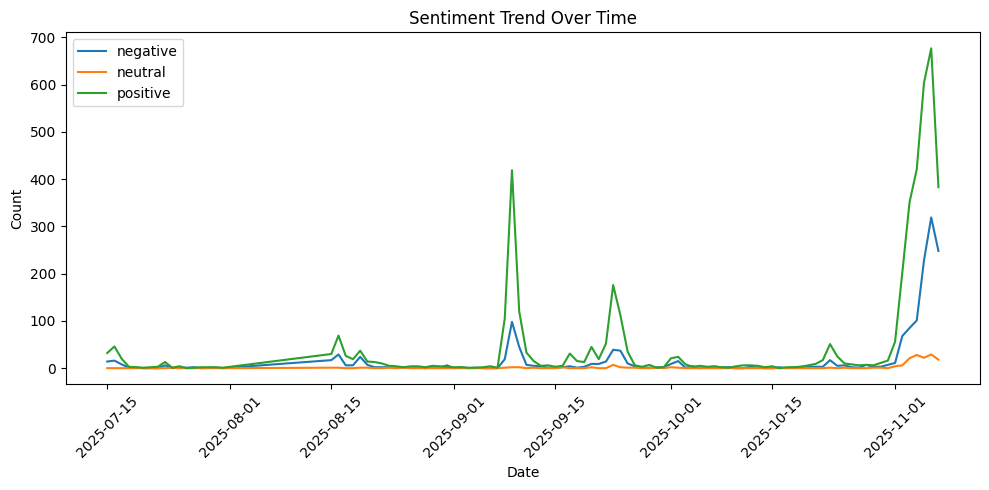

In [ ]:
df_final['published_at'] = pd.to_datetime(df_final['published_at'])

sent_trend = df_final.groupby([df_final['published_at'].dt.date, 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
for col in sent_trend.columns:
    plt.plot(sent_trend.index, sent_trend[col], label=col)

plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## **Using 1000 Labeled Data And Balancing**

## **Load Dataset**

In [ ]:
indobert_file = "/content/drive/MyDrive/Akademik - UNESA /Semester 3/Processing Text/008_130_213_Group5_PemteksFinalProject/Cleaning Data Result/Cleaning_Data_IndoBERT_Labeled_1000.xlsx"

In [ ]:
import pandas as pd
from IPython.display import display

df = pd.read_excel(indobert_file)
display(df.head())

,text_display,cleaned_text,published_at,author,like_count,label
0,Bagus pak Purbaya sikat kalau sdh ngaco berhub...,bagus bapak purbaya sikat kalau sudah ngaco be...,2025-11-07 09:33:05,@hendywirawan6870,0,positive
1,Bener sekali kalo mau pinjam kur harus ada ang...,benar sekali kalau mau pinjam kur harus ada an...,2025-11-07 09:32:53,@Farah-hl5ct,0,positive
2,mantul pak menkeu,mantul bapak menteri keuangan,2025-11-07 07:55:01,@indrapujiwiyatno,0,positive
3,kita baru tahu slama bertahun2 slama ini baru ...,kita baru tahu slama bertahun slama ini baru a...,2025-11-06 19:33:45,@marliaheumarvggy5850,0,negative
4,pak purbaya sehat selalu panjang umur,bapak purbaya sehat selalu panjang umur,2025-11-06 19:31:00,@marliaheumarvggy5850,0,positive


## **Labeled Data**

### **Filter Labeled Data and Prepare Text Columns**

In [ ]:
print("Columns in DataFrame df:", df.columns)
df_labeled = df[df['label'].notnull()].copy()
print(f"Jumlah data berlabel: {len(df_labeled)}")

text_column = 'cleaned_text'
if text_column not in df_labeled.columns:
    df_labeled[text_column] = ""

df_labeled.loc[:, text_column] = df_labeled[text_column].astype(str).fillna("")
display(df_labeled.head())

Columns in DataFrame df: Index(['text_display', 'cleaned_text', 'published_at', 'author', 'like_count',
       'label'],
      dtype='object')
Jumlah data berlabel: 1000


,text_display,cleaned_text,published_at,author,like_count,label
0,Bagus pak Purbaya sikat kalau sdh ngaco berhub...,bagus bapak purbaya sikat kalau sudah ngaco be...,2025-11-07 09:33:05,@hendywirawan6870,0,positive
1,Bener sekali kalo mau pinjam kur harus ada ang...,benar sekali kalau mau pinjam kur harus ada an...,2025-11-07 09:32:53,@Farah-hl5ct,0,positive
2,mantul pak menkeu,mantul bapak menteri keuangan,2025-11-07 07:55:01,@indrapujiwiyatno,0,positive
3,kita baru tahu slama bertahun2 slama ini baru ...,kita baru tahu slama bertahun slama ini baru a...,2025-11-06 19:33:45,@marliaheumarvggy5850,0,negative
4,pak purbaya sehat selalu panjang umur,bapak purbaya sehat selalu panjang umur,2025-11-06 19:31:00,@marliaheumarvggy5850,0,positive


In [ ]:
print(df_labeled['label'].value_counts())

label
negative    421
positive    372
neutral     207
Name: count, dtype: int64


# **Balance Labeled Data by Class**

In [ ]:
from sklearn.utils import resample

max_count = df_labeled['label'].value_counts().max()
balanced_dfs = []
for lbl in df_labeled['label'].unique():
    df_label = df_labeled[df_labeled['label'] == lbl]
    df_upsampled = resample(df_label,
                            replace=True,
                            n_samples=max_count,
                            random_state=42)
    balanced_dfs.append(df_upsampled)

df_labeled = pd.concat(balanced_dfs).reset_index(drop=True)

display(df_labeled['label'].value_counts())

,count
label,
positive,421
negative,421
neutral,421


### **Label Encoding and Tokenizer**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
le = LabelEncoder()
df_labeled['label_id'] = le.fit_transform(df_labeled['label'])

def tokenize_function(texts, max_len=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

### **Dataset Class**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

### **Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_labeled[text_column].tolist(),
    df_labeled['label_id'].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=df_labeled['label_id']
)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

train_dataset = CommentDataset(train_encodings, train_labels)
val_dataset = CommentDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### **Load Model and Optimizer**

In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=len(le.classes_)
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Training Loop with Early Stopping**

In [ ]:
from tqdm import tqdm

epochs = 5
best_val_loss = float('inf')
patience = 2
trigger_times = 0

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
            val_loss += outputs.loss.item()
    val_loss /= len(val_loader)
    print(f"Validation loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

Epoch 1: 100%|██████████| 56/56 [00:18<00:00,  2.95it/s, loss=0.569]


Validation loss: 0.5295


Epoch 2: 100%|██████████| 56/56 [00:19<00:00,  2.93it/s, loss=0.478]


Validation loss: 0.3527


Epoch 3: 100%|██████████| 56/56 [00:18<00:00,  2.96it/s, loss=0.0573]


Validation loss: 0.3047


Epoch 4: 100%|██████████| 56/56 [00:19<00:00,  2.95it/s, loss=0.044]


Validation loss: 0.4070


Epoch 5: 100%|██████████| 56/56 [00:19<00:00,  2.91it/s, loss=0.154]


Validation loss: 0.3804
Early stopping!


### **Load Best Model**

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

### **Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=le.classes_)
print(f"Validation accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Validation accuracy: 0.8971
Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.85      0.88       126
     neutral       0.84      0.90      0.87       126
    positive       0.94      0.94      0.94       127

    accuracy                           0.90       379
   macro avg       0.90      0.90      0.90       379
weighted avg       0.90      0.90      0.90       379



## **Unlabeled Data**

### **Unlabeled Data Prediction (Confidence Filtering)**

In [ ]:
confidence_threshold = 0.95
df_unlabeled = df[df['label'].isnull()].copy()
df_unlabeled.loc[:, text_column] = df_unlabeled[text_column].astype(str).fillna("")

batch_size = 16
all_preds, all_confs = [], []

model.eval()
for i in range(0, len(df_unlabeled), batch_size):
    batch_texts = df_unlabeled[text_column][i:i+batch_size].tolist()
    enc_batch = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    enc_batch = {k: v.to(device) for k, v in enc_batch.items()}

    with torch.no_grad():
        outputs = model(**enc_batch)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confs, pred_ids = torch.max(probs, dim=1)

    all_preds.extend(pred_ids.cpu().numpy())
    all_confs.extend(confs.cpu().numpy())

df_unlabeled['pred_label'] = le.inverse_transform(all_preds)
df_unlabeled['confidence'] = all_confs

df_confident_high = df_unlabeled[df_unlabeled['confidence'] >= confidence_threshold].copy()
print(f"High number of confident comments: {len(df_confident_high)}")

df_confident_high['label_id'] = le.transform(df_confident_high['pred_label'])

High number of confident comments: 2413


## **Combine Labeled and Confident Data for Fine-tune**

In [ ]:
df_finetune = pd.concat([
    df_labeled,
    df_confident_high[[text_column,'pred_label','label_id']].rename(columns={'pred_label':'label'})
], ignore_index=True)

print(f"Total data for fine-tune: {len(df_finetune)}")

encodings_finetune = tokenize_function(df_finetune[text_column].tolist())
labels_finetune = df_finetune['label_id'].tolist()
dataset_finetune = CommentDataset(encodings_finetune, labels_finetune)
dataloader_finetune = DataLoader(dataset_finetune, batch_size=16, shuffle=True)

Total data for fine-tune: 3676


### **Fine-tune Model**

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 2

for epoch in range(epochs):
    model.train()
    loop = tqdm(dataloader_finetune, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Fine-tune Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())

Fine-tune Epoch 2: 100%|██████████| 230/230 [01:18<00:00,  2.93it/s, loss=0.0273]


## **Final Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=le.classes_)
print(f"Final validation accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Final validation accuracy: 0.9789
Classification Report:
               precision    recall  f1-score   support

    negative       0.99      0.98      0.98       126
     neutral       1.00      0.97      0.98       126
    positive       0.95      0.99      0.97       127

    accuracy                           0.98       379
   macro avg       0.98      0.98      0.98       379
weighted avg       0.98      0.98      0.98       379



## **Final Prediction of Unlabeled Data**

In [ ]:
all_preds, all_confs = [], []
for i in range(0, len(df_unlabeled), batch_size):
    batch_texts = df_unlabeled[text_column][i:i+batch_size].tolist()
    enc_batch = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    enc_batch = {k: v.to(device) for k, v in enc_batch.items()}

    with torch.no_grad():
        outputs = model(**enc_batch)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confs, pred_ids = torch.max(probs, dim=1)

    all_preds.extend(pred_ids.cpu().numpy())
    all_confs.extend(confs.cpu().numpy())

df_unlabeled['pred_label'] = le.inverse_transform(all_preds)
df_unlabeled['confidence'] = all_confs
df_unlabeled.index = df[df['label'].isnull()].index

df_final = df.copy()
df_final.loc[df_unlabeled.index, 'label'] = df_unlabeled['pred_label']

df_final.to_excel("Cleaning_Data_IndoBERT_Sentiment_Label_Fix.xlsx", index=False)
print("Done! File saved: Cleaning_Data_IndoBERT_Sentiment_Label_Fix.xlsx")
display(df_final[[text_column, 'published_at', 'label']].head(20))

Done! File saved: Cleaning_Data_IndoBERT_Sentiment_Label_Fix.xlsx


,cleaned_text,published_at,label
0,bagus bapak purbaya sikat kalau sudah ngaco be...,2025-11-07 09:33:05,positive
1,benar sekali kalau mau pinjam kur harus ada an...,2025-11-07 09:32:53,positive
2,mantul bapak menteri keuangan,2025-11-07 07:55:01,positive
3,kita baru tahu slama bertahun slama ini baru a...,2025-11-06 19:33:45,negative
4,bapak purbaya sehat selalu panjang umur,2025-11-06 19:31:00,positive
5,dipecat saja masih banyak orang orang pintar y...,2025-11-06 14:41:28,negative
6,baru kali ini lihat orang berbicara sombong ta...,2025-11-06 13:04:29,positive
7,betul semua diminta agunan kami yang di daerah...,2025-11-06 11:22:36,neutral
8,seharusnya danantara itu sebagai tempat ekseku...,2025-11-05 22:51:58,negative
9,saya pengguna kur dan memang boleh lah kalau u...,2025-11-05 22:48:10,neutral


#**Sentiment Distribution**

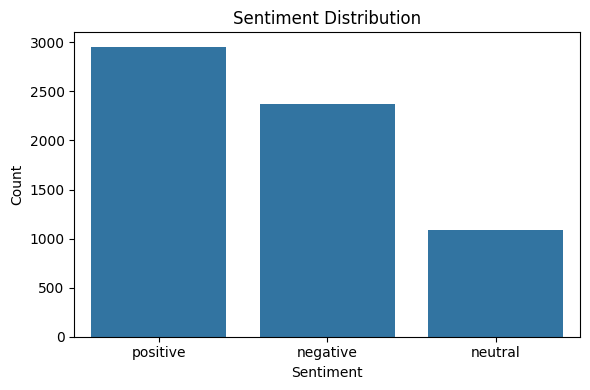

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df_final, x='label')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

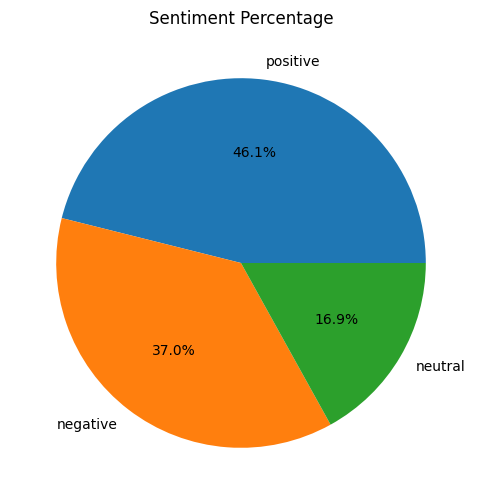

In [ ]:
plt.figure(figsize=(6,6))
df_final['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel="")
plt.title("Sentiment Percentage")
plt.show()

# **Sentiment Trend Over Time**

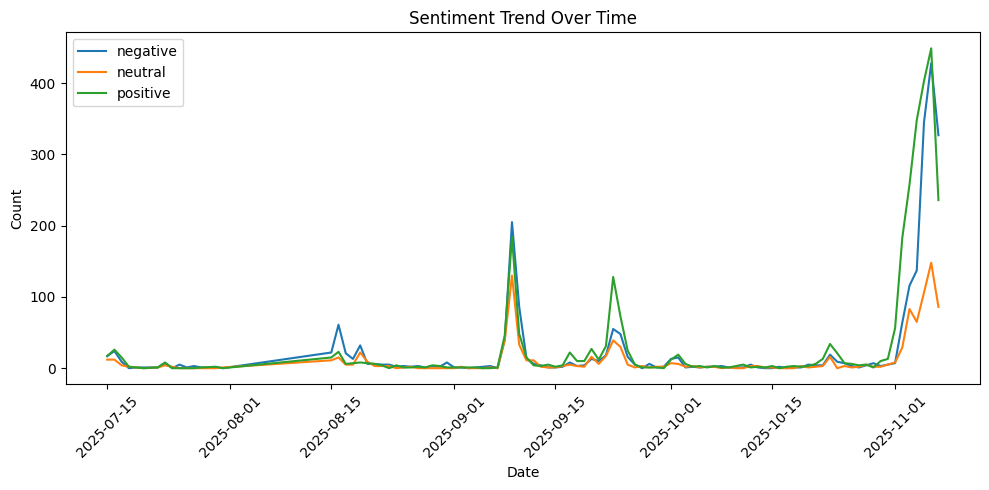

In [ ]:
df_final['published_at'] = pd.to_datetime(df_final['published_at'])

sent_trend = df_final.groupby([df_final['published_at'].dt.date, 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
for col in sent_trend.columns:
    plt.plot(sent_trend.index, sent_trend[col], label=col)

plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()